In [46]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic3"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import (
    load_demograhics, 
    load_buurt_data, 
    willingness_to_cycle, 
    add_willingness_to_cycle_column, 
    align_by_buurt,
    punt_buurt_code_column, 
    punt_travel_time_column,
    demographics_population_column
)

In [59]:
mode = "ebike"
punt1 = "basis"
location = "Education"

df_demographics = load_demograhics()
df_punt = load_buurt_data(punt1, mode=mode)

Loaded file from CSV


In [60]:
df_punt, df_demographics = align_by_buurt(df_punt, df_demographics,)

Demographics and filtered dataframes do not match in length: 14405 vs 9956232, ignoring missing values


In [61]:
ebike_max = 25
col_time_base = "ebike_time_"
col_willingness_base = "ebike_willingness_"
col_willing_number_base = "ebike_willingness_number_"

range_speeds = range(15, 35)
population_willling = []

for speed in range_speeds:
    ratio = ebike_max / speed
    col_time = col_time_base + str(speed)
    col_willingness = col_willingness_base + str(speed)
    col_willing_number = col_willing_number_base + str(speed)

    df_punt[col_time] = df_punt[punt_travel_time_column] * ratio
    df_punt[col_willingness] = willingness_to_cycle(df_punt[col_time], location=location, mode=mode)
    df_punt[col_willing_number] = df_demographics[demographics_population_column] * df_punt[col_willingness]

    population_willling.append(df_punt[col_willing_number].sum())

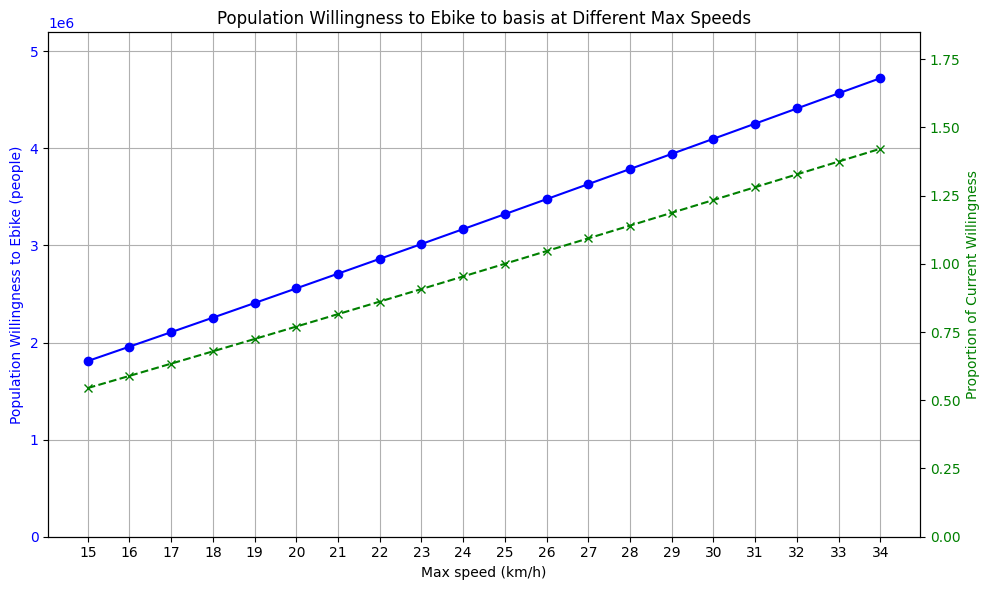

In [62]:
pop_current = population_willling[np.argwhere(np.array(range_speeds) == ebike_max)[0][0]]
proportions = [val / pop_current for val in population_willling]

plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(range_speeds, population_willling, marker='o', color='b')
ax1.set_xlabel("Max speed (km/h)")
ax1.set_ylabel("Population Willingness to Ebike (people)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range_speeds)
ax1.set_title(f"Population Willingness to Ebike to {punt1} at Different Max Speeds")
ax1.set_ylim(0, max(population_willling) * 1.1)  # Adjust y-axis limit for better visibility
ax1.grid()

# Twin axis for proportion
ax2 = ax1.twinx()
ax2.plot(range_speeds, proportions, marker='x', color='g', linestyle='--')
ax2.set_ylabel("Proportion of Current Willingness", color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(0, max(proportions) * 1.3)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.savefig(f"graphics/population_willingness_to_cycle_ebike_speeds_{punt1}.png", dpi=300)
plt.show()